In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sympy import *

### cleaning

In [ ]:
df_b = pd.read_csv('data/BBRs_5538500_5538999.csv')


In [ ]:
df_p = pd.read_csv('data/custom_ppds_output.csv')
df_p

In [ ]:
df_p.sort_values(by='slot', ascending=True, inplace=True)

In [ ]:
df_p.drop_duplicates(subset=['slot'], keep='first', inplace=True)

In [ ]:
df_p.reset_index(drop=True, inplace=True)

In [ ]:
df_p.rename(columns={'buidler_pubkey': 'builder_pubkey'}, inplace=True)
df_p.rename(columns={'buidler_name': 'builder_name'}, inplace=True)


In [ ]:
df_p.info()

In [ ]:
print(df_p['builder_name'].unique())
df_p = df_p[['slot', 'block_hash', 'block_reward', 'gas_used', 'validator_pubkey', 'builder_pubkey', 'builder_name', 'relay_name']]


In [ ]:
df_p['boosted'] = True

In [ ]:
slot = np.arange(4700013, df_p['slot'].max())
# first slot after Ethereum merge https://etherscan.io/block/15537394
df = pd.DataFrame(slot, columns = ['slot'])


In [ ]:
df = df.merge(df_p, how='left', on='slot')
df['builder_name'].fillna('No builder', inplace=True)
df['builder_name'].replace('Ø\x83\x01\x0b\x84geth\x88go1.19.1\x85linux', 'coda_geth_linux', inplace=True)


### descriptive statistics

In [13]:
slots_per_hour = 5*60
slots_per_day = 5*60*24

total_slots = len(df)
total_epochs = int(len(df)/32)
total_days = total_slots / slots_per_day

In [ ]:
fltr = 'builder_name'
#fltr = 'builder_pubkey'

df['count'] = 1
df['position'] = 1
count = 0
for i in range(0, len(df)):
    check = (df[fltr].iloc[i] == df[fltr].iloc[i-1]) & (df[fltr].iloc[i] != 'Unknown') & (df[fltr].iloc[i] != 'No builder')
    
    if check == True:
        if count == 0:
            count = 2
        else:
            count += 1

    elif (check == False) & (count == 0):
            continue

    elif (check == False) & (count != 0):
        for j in range(1, count+1):
            df['count'].iloc[i-j] = count
            df['position'].iloc[i-j] = count+1-j

        count = 0




In [ ]:
#df['block_reward'].fillna((df[df['count'] == 1]['block_reward'].mean()), inplace=True)

In [ ]:
df_backup = df.copy()

In [ ]:
df.groupby(df['count']).size()

In [97]:
stat = df.groupby(df['count']).size().values

temp = df['count'].unique()
temp.sort()

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60/24), 'days we find:')

for i, x in enumerate(temp):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', x, 'consecutive blocks')

print('proposed by the same builder')

In a dataset of 886743 blocks 123 days we find:
704941 instances of 1 consecutive blocks
63099 instances of 2 consecutive blocks
12652 instances of 3 consecutive blocks
2887 instances of 4 consecutive blocks
756 instances of 5 consecutive blocks
222 instances of 6 consecutive blocks
80 instances of 7 consecutive blocks
24 instances of 8 consecutive blocks
16 instances of 9 consecutive blocks
4 instances of 10 consecutive blocks
2 instances of 11 consecutive blocks
1 instances of 13 consecutive blocks
1 instances of 17 consecutive blocks
proposed by the same builder


In [ ]:
print(stat[0]/len(df), '% normal blocks')
print(stat[1]*2/len(df), '% k=2 blocks')
print(stat[2]*3/len(df), '% k=3 blocks')
print(stat[3]*4/len(df), '% k=4 blocks')
print(1-stat[0]/len(df)-stat[1]*2/len(df)-stat[2]*3/len(df)-stat[3]*4/len(df))

In [ ]:
5*60*24*stat[1]*2/len(df)/2

In [ ]:
print(df['builder_name'].unique())
print(df.groupby(df['builder_name']).size().sort_values(ascending=False))

In [ ]:
lst = list(df['builder_name'].unique())
calc = pd.DataFrame(lst, columns = ['builder_name'])

temp_lst = []
for x in lst:
    temp_lst.append(len(df[df['builder_name'] == x]))

calc['slots'] = temp_lst

calc['share'] = np.round(calc['slots']/len(df),4)

for i in range(1,20+1):
    temp_lst = []
    
    for x in lst:
        temp_lst.append(int(len(df[(df['builder_name'] == x) & (df['count'] == i)])/i))
    
    name = f'k_{i}'
    calc[name] = temp_lst

calc

In [ ]:
calc.iloc[:,0:13]

In [ ]:
df['epoch'] = 1663224179

In [ ]:
def multiply_row_index(df, column_name):
    for index, row in df.iterrows():
        df.at[index, column_name] = row[column_name] + index*12
    return df

df = multiply_row_index(df, 'epoch')

In [ ]:
df['date'] = pd.to_datetime(df['epoch'],  unit='s', utc=True)

In [ ]:
df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [ ]:
df.to_csv('data/df.csv', index=False)

In [54]:
df = pd.read_csv('data/df.csv')
df = df.drop('Unnamed: 0', axis=1)
df['date'] = pd.to_datetime(df['epoch'],  unit='s', utc=True)


In [42]:
df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')

### plotting descriptive

#plot distribution over builder

In [79]:
print(len(df[df['boosted'] != True]), 'blocks without PBS') 
print(len(df[df['boosted'] == True]), 'blocks with PBS')
print(len(df[df['boosted'] == True])/len(df)*100, '%')


236167 blocks without PBS
650576 blocks with PBS
73.3669169082812 %


In [65]:
df['slot'].iloc[-1]

5586755

In [80]:
df['boosted'].rolling(slots_per_day, min_periods=1).sum()/slots_per_day

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
886738    0.907222
886739    0.907222
886740    0.907222
886741    0.907083
886742    0.907083
Name: boosted, Length: 886743, dtype: float64

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25809/3482829089.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


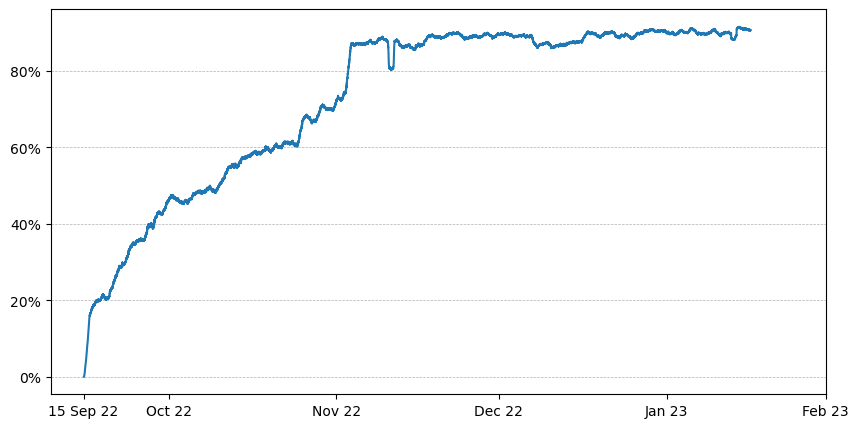

In [78]:
fig, ax = plt.subplots(figsize =(10, 5))

ax.plot(df['slot'], df['boosted'].rolling(slots_per_day, min_periods=1).sum()/slots_per_day)

# ax.ticklabel_format(style='plain')

ax.grid(axis='y', linestyle='--', linewidth=.5)

s = df['slot'].iloc[0]
o = df[df['date'] >= '2022-10-01 00:00:00']['slot'].values[0]
n = df[df['date'] >= '2022-11-01 00:00:00']['slot'].values[0]
d = df[df['date'] >= '2022-12-01 00:00:00']['slot'].values[0]
j = df[df['date'] >= '2023-01-01 00:00:00']['slot'].values[0]
f = df['slot'].iloc[-1]+1e5


plt.xticks([s, o, n, d, j, f], ['15 Sep 22', 'Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23'])
       
left, right = plt.xlim()
ax.set_xlim(left+1, right-0)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.savefig(f'figures/mev_boost.png')

plt.show()

In [82]:
bins = np.arange(df['slot'].min(), df['slot'].max(), slots_per_day)
data = []
for i in range(0, len(bins)-1):
        data.append(df[(df['slot'] >= bins[i]) & (df['slot'] < bins[i+1])]['block_reward'].mean())

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25809/117954857.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


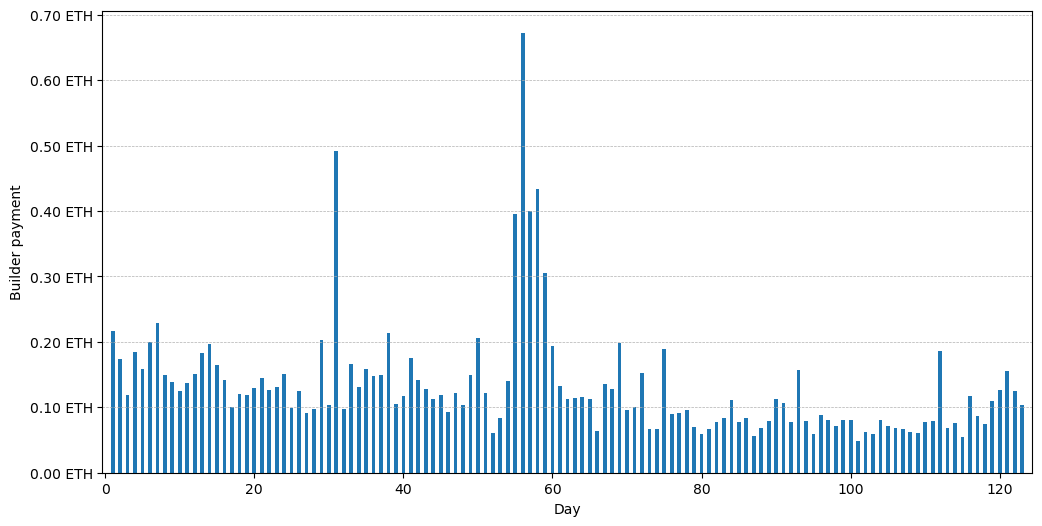

In [83]:
fig, ax = plt.subplots(figsize =(12, 6))

ax.bar(np.arange(1,len(data)+1), data, width = 0.5)
ax.grid(axis='y', linestyle='--', linewidth=.5)

left, right = plt.xlim()
ax.set_xlim(left+5, right-5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Day')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

# show plot
plt.show()

ToDo add percentage; trend line; rate of increase..

### plotting analysis

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25809/2613085636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slc.dropna(subset=['block_reward'], inplace=True)
/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25809/2613085636.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


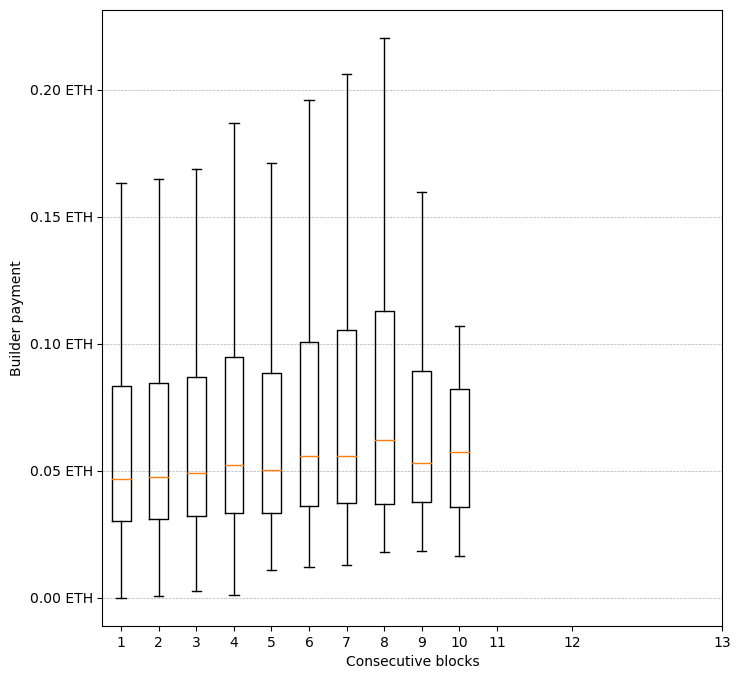

In [84]:
temp = df['count'].unique()
temp.sort()

slc = df[df['count'] <= 10]
slc.dropna(subset=['block_reward'], inplace=True)

data = []
for x in temp:
    data.append(list(slc[slc['count']==x]['block_reward']))

fig, ax = plt.subplots(figsize =(8, 8))

ax.boxplot(data, showfliers=False)
ax.grid(axis='y', linestyle='--', linewidth=.5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Consecutive blocks')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(temp)

plt.savefig(f'figures/payment_pubkey.png')
plt.show()


In [85]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [ ]:
#exclude without significant data
lst = df[df['count'] >= 9].index

df.drop(lst, inplace=True)

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25809/188394192.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


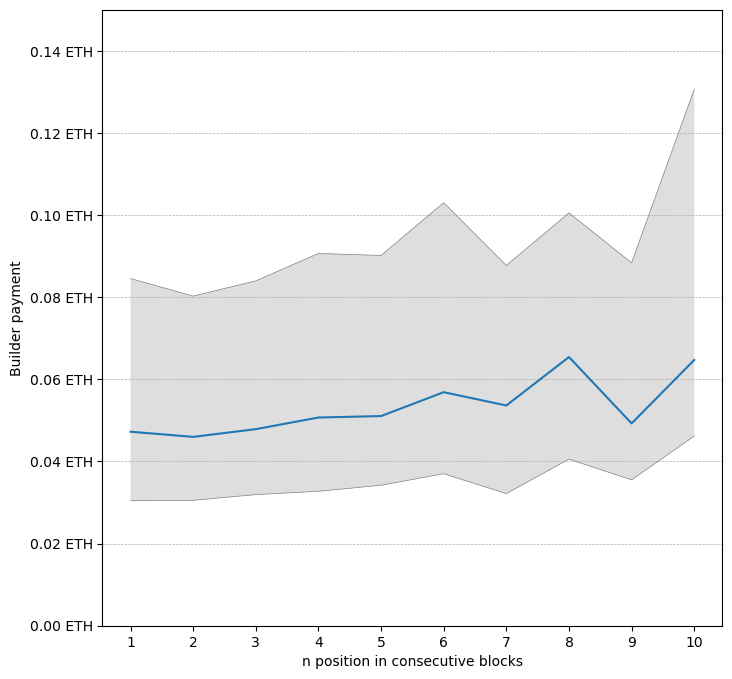

In [86]:
#how much do builder pay on average for consecutive blocks

#add cumulative payment

slc = df[df['count'] <= 10]


fig, ax = plt.subplots(figsize =(8, 8))

x = list(slc['position'].unique())

ax.plot(x, slc['block_reward'].groupby(slc['position']).median())
ax.grid(axis='y', linestyle='--', linewidth=.5)


y1 = slc.groupby(['position']).agg({'block_reward': [q25]})
y2 = slc.groupby(['position']).agg({'block_reward': [q75]})
ax.plot(x, y1, x, y2, color='grey', linewidth=.5)

ax.fill_between(x, list(y1.iloc[:, 0]), list(y2.iloc[:, 0]), facecolor='lightgrey', alpha=.75)


#data = slc[df['count'] >= 2]
#ax.scatter(data['position'], data['block_reward'], s = .05, alpha = .75)

ax.set_ylabel('Builder payment')
ax.set_xlabel('n position in consecutive blocks')

plt.ylim(0, .15)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(list(slc['position'].unique()))

plt.savefig(f'figures/payment_position_pubkey.png')

plt.show()


In [87]:
df

,slot,block_hash,block_reward,gas_used,validator_pubkey,builder_pubkey,builder_name,relay_name,boosted,count,position,epoch,date
0,4700013,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1663224179,2022-09-15 06:42:59+00:00
1,4700014,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1663224191,2022-09-15 06:43:11+00:00
2,4700015,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1663224203,2022-09-15 06:43:23+00:00
3,4700016,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1663224215,2022-09-15 06:43:35+00:00
4,4700017,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1663224227,2022-09-15 06:43:47+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886738,5586751,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1673865035,2023-01-16 10:30:35+00:00
886739,5586752,0xad1be4394d52d6f848baa216ccfac0b250cd51f5a4a2...,0.045863,25229702.0,0xa7b4840468fbd50602db4cf35a56af9ea11fffac41b5...,0x9000009807ed12c1f08bf4e81c6da3ba8e3fc3d95389...,blocknative,Blocknative,True,1,1,1673865047,2023-01-16 10:30:47+00:00
886740,5586753,0xff6dbe03e2510fa1430e12a2f2746f4ffc440ea8f1d2...,0.015468,13140362.0,0x89fd95e3bb0da3d02ca91285c334a1b57f2e22547fef...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,True,1,1,1673865059,2023-01-16 10:30:59+00:00
886741,5586754,NaN,NaN,NaN,NaN,NaN,No builder,NaN,NaN,1,1,1673865071,2023-01-16 10:31:11+00:00


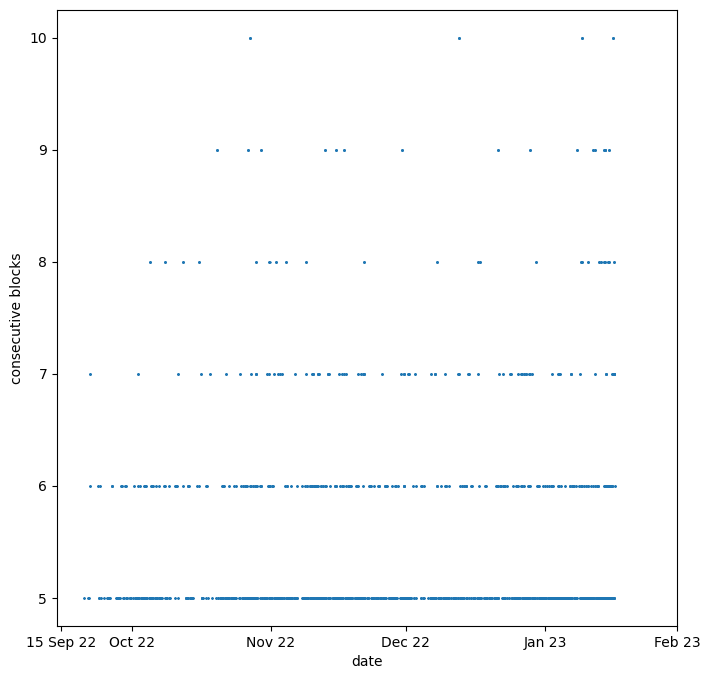

In [93]:
#how much do builder pay on average for consecutive blocks

#add cumulative payment

slc = df[(df['count'] <11) & (df['count'] >= 5)]

fig, ax = plt.subplots(figsize =(8, 8))

ax.scatter(slc['slot'], slc['count'], s=.25)

ax.set_ylabel('consecutive blocks')
ax.set_xlabel('date')

s = df['slot'].iloc[0]
o = df[df['date'] >= '2022-10-01 00:00:00']['slot'].values[0]
n = df[df['date'] >= '2022-11-01 00:00:00']['slot'].values[0]
d = df[df['date'] >= '2022-12-01 00:00:00']['slot'].values[0]
j = df[df['date'] >= '2023-01-01 00:00:00']['slot'].values[0]
f = df['slot'].iloc[-1]+1e5


plt.xticks([s, o, n, d, j, f], ['15 Sep 22', 'Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23'])
       


plt.savefig(f'figures/scatter_slots.png')

plt.show()


In [98]:
stat

array([704941,  63099,  12652,   2887,    756,    222,     80,     24,
           16,      4,      2,      1,      1])

In [ ]:
stat = df.groupby(df['count']).size().values



array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 17])

2 63099
3 12652
4 2887
5 756
6 222
7 80
8 24
9 16
10 4


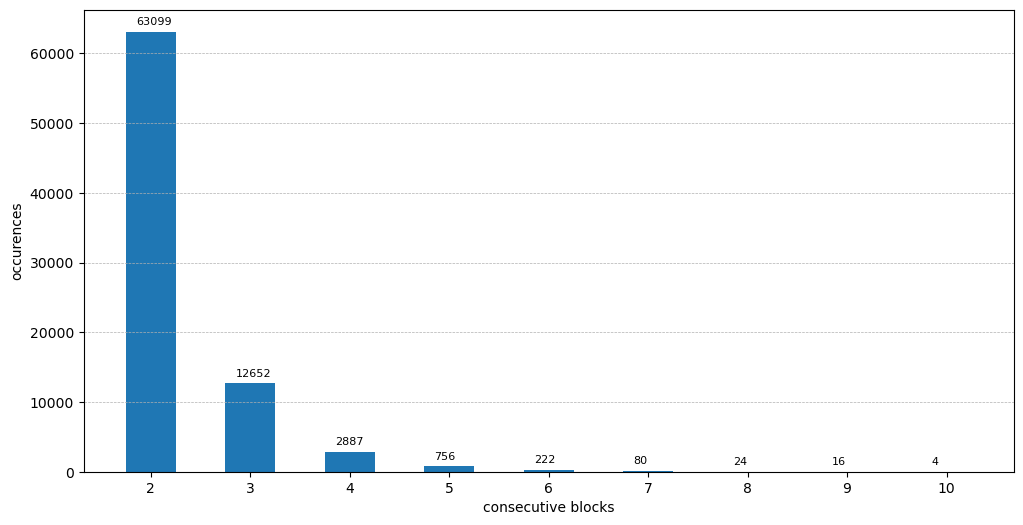

In [143]:
slc = df[(df['count'] >= 2) & (df['count'] <= 10)]

temp = slc['count'].unique()
temp.sort()

stat = slc.groupby(slc['count']).size().values

for i, x in enumerate(temp):
    stat[i] = stat[i]/x

fig, ax = plt.subplots(figsize =(12, 6))

ax.bar(temp, stat, width = 0.5)
ax.grid(axis='y', linestyle='--', linewidth=.5)


for i in range(0,len(temp)):
    plt.text(temp[i]-.15, stat[i]+1e3, s=f'{stat[i]}', fontdict=dict(fontsize=8))
    print(temp[i], stat[i])


ax.set_ylabel('occurences')
ax.set_xlabel('consecutive blocks')

plt.xticks(temp)

plt.savefig(f'figures/occurences.png')
# show plot
plt.show()

In [ ]:
# Is there a pattern, to propose low gas blocks?
# "VALIDATOR for slot k+1 is buying the slot in order to submit an empty block just before the slot they are elected for"
# > Validators could be "unknown"

n, bins, patches = plt.hist(df[df['boosted']==True]['gas_used'], 50, density=True, facecolor='g', alpha=0.75)

temp = df[(df['boosted']==True) & (df['gas_used'] < 0.75e7)]

In [ ]:
temp

In [ ]:
print(temp.groupby(['builder_name']).size())

In [ ]:
pd.set_option("display.max_rows", None)
temp.groupby(['builder_name', 'count', 'position']).size().to_frame(name='vals')

### math

In [ ]:
n = 3
k = 1
p = .5
2*(n-(k+1)+1)*(p**(k+1))

In [ ]:
n = 3
k = 1
p = .5
1*(n-k+1)*(p**k)-2*((n-(k+1)+1)*(p**(k+1))-2*(n-(k+2)+1)*(p**(k+2)))-3*(n-(k+2)+1)*(p**(k+2))

In [ ]:
n = 3
k = 2
p = .5
(n-k+1)*(p**k)-2*(n-(k+1)+1)*(p**(k+1))

In [ ]:
-2*(n-(k+1)+1)*(p**(k+1))-2*(n-(k+2)+1)*(p**(k+2))

In [ ]:
n = 3
k = 3
p = .5
(n-k+1)*(p**k)

In [ ]:
#What is the probability of exactly k consecutive heads in n tosses?

p = 99/100 #probability
n = 2 #tosses
k = 2 #k consecutive tosses


print('gesamt', p**k*(1-p)**2*max(0,(n-k-1))+p**k*(1-p)*2)

print('term a', p**k*(1-p)**2*max(0,(n-k-1)))
print('term b', p**k*(1-p)*2)

print('equation', f'{p}**{k}*(1-{p})**2*{max(0, n-k-1)}+{p}**{k}*(1-{p})*2')

In [ ]:
#What is the probability of exactly k consecutive heads in n tosses?

p = 99/100 #probability
n = 3 #tosses
k = 1 #k consecutive tosses


print('gesamt', p**k*(1-p)**2*max(0,(n-k-1))+p**k*(1-p)*max(0,n-k)*2+p**k*max(0,k-n+1))
print('a', p**k*(1-p)**2*max(0,(n-k-1)))
print('b', p**k*(1-p)*max(0,k-n)*2)
print('c', p**k*max(0,k-n+1))

In [ ]:
n = 3
k = 2
(n-k+1)/(2**k)-(n-k)/(2**(k+1))*2

In [ ]:
n = 3
k = 3
(n-k+1)/(2**k)

In [ ]:
def prob(c, p):
    # c = consecutive blocks
    # n = slots
    # p = share MEV boost
    
    x = symbols('x', real=True)

    c = c; n = 32; p = p

    xx = min(i for i in solve(1-x+(1-p)*p**c*x**(c+1)) if i > 1)
    qn = ((1 - p*xx) / ((c + 1 - c*xx)*(1-p))) * (1/(xx**(n+1)))
    
    return qn*100, (1-qn)*100

    

In [ ]:
calc

In [ ]:
calc[:,0:13]

In [ ]:
lst = list(df['builder_name'].unique())
expt = calc[['builder_name', 'slots', 'share']]


In [ ]:
lst

In [ ]:
expt

In [ ]:
lst

In [ ]:

temp_lst = [0,1,2,3,4,5,6,7,8,9]
temp_lst.append(temp_lst)

expt['e_1'] = temp_lst

for c in range(2,5+1):
    temp_lst = []
    
    for x in lst:
        p = float(expt[expt['builder_name'] == x]['share'].values)
        no_success, success = prob(c, p)
        temp_lst.append(int(np.round(float(success)/100*total_epochs,0)))
    
    name = f'e_{c}'
    expt[name] = temp_lst
    

In [ ]:
expt

In [ ]:
calc

In [ ]:
p = np.round(len(df[df['builder_name'] == 'beaverbuild.org'])/1500,4)

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we expect ..')
for i in [1,2,3,4,5]:
    c = i
    no_success, success = prob(c, p)
    print(i, 'consecutive blocks: Probability', np.round(float(success),2), '% - Instances:', np.round(float(success)/100*47,0))

print('.. proposed by the same builder')


In [ ]:
stat = df[df['builder_name'] == 'beaverbuild.org'].groupby(['count']).size().values

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we find ..')

for i, x in enumerate(np.sort(df[df['builder_name'] == 'beaverbuild.org']['count'].unique())):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', i+1, 'consecutive blocks')
    
print('.. proposed by the same builder')

In [ ]:
## MATRIX
cons_blocks = np.arange(2,5+1) #cons_blocks
prob = np.arange(.1,.9+.05,.05)

In [ ]:
lst = []
for p in prob:
    lst_temp = []
    lst_temp.append(x)
    for c in cons_blocks:
        no_success, success = prob(c, p)
        lst_temp.append(success)
    
    for z in range(0, len(lst_temp)):
        try: 
            lst_temp[z] = np.round(float(lst_temp[z]), 2)
        except TypeError:
            lst_temp[z] = 100
        
    lst.append(lst_temp)
        

In [ ]:
df = pd.DataFrame(lst, columns =['probability', 'k=2', 'k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
df = df.set_index('probability')
df

In [ ]:
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*225, 'k=5 consecutive blocks a day.')
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*6759, 'k=5 consecutive blocks a month.')
